In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou

In [6]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [7]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

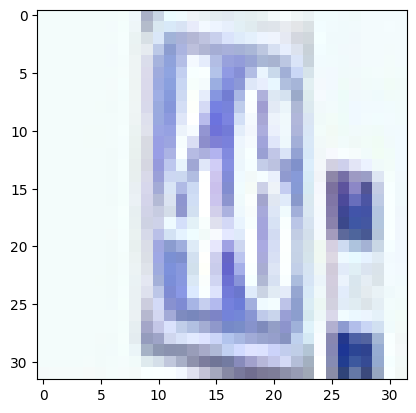

In [8]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

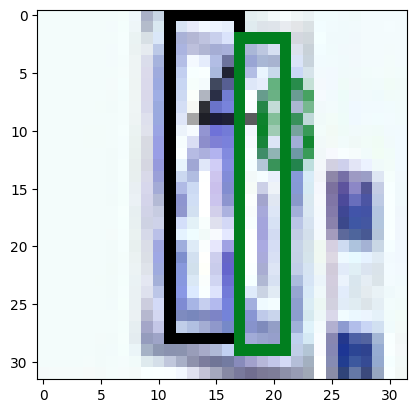

In [9]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [10]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [11]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]]), tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]])]
tensor([[0.4533, 0.4565, 0.1963, 0.8696],
        [0.6075, 0.5000, 0.1495, 0.8696]])


NameError: name 'anchors' is not defined

In [12]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [13]:
targets[0, 0, 0, :], targets[0, 1, 1, :]

NameError: name 'targets' is not defined

In [14]:
import json

In [86]:
torch.manual_seed(0)

config = json.load(open("./configs/smol.json", "r"))
model = MiniYoloV3.from_config(config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=1500,
    lr=3e-3,
    lambda_coord=1,
    lambda_noobj=1,
    device="cpu"
)

In [87]:
trainer.train()

100%|██████████| 1500/1500 [00:16<00:00, 90.35it/s, class_loss=0.000569, coord_loss=7.71e-6, loss=0.00678, noobj_loss=0.00374, obj_conf_loss=0.00247] 


[47.586517333984375,
 42.00914001464844,
 39.11616516113281,
 36.94428634643555,
 34.97654724121094,
 33.58151626586914,
 32.284732818603516,
 31.119739532470703,
 30.09564781188965,
 29.14691925048828,
 28.311676025390625,
 27.570343017578125,
 26.89602279663086,
 26.265165328979492,
 25.659372329711914,
 25.062660217285156,
 24.466691970825195,
 23.88253402709961,
 23.31314468383789,
 22.759096145629883,
 22.217880249023438,
 21.66574478149414,
 21.109445571899414,
 20.555936813354492,
 20.00580596923828,
 19.4531192779541,
 18.903621673583984,
 18.361249923706055,
 17.831092834472656,
 17.312213897705078,
 16.8073673248291,
 16.316160202026367,
 15.836323738098145,
 15.366692543029785,
 14.905529975891113,
 14.448742866516113,
 13.999703407287598,
 13.557324409484863,
 13.123283386230469,
 12.700898170471191,
 12.289709091186523,
 11.88758373260498,
 11.49498462677002,
 11.114045143127441,
 10.750215530395508,
 10.387523651123047,
 10.034345626831055,
 9.694286346435547,
 9.36366367

In [88]:
pred = model(batch["images"])
pred.shape

torch.Size([2, 8, 8, 60])

In [89]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([ 0.3254, -0.5311,  0.1190, -0.4809, -6.0680, -0.8017,  1.4865, -1.2680,
         -0.7199, -0.7871, -1.0761, -0.7767,  0.0545, -1.1350, -1.4011, -0.1118,
         -0.1187, -0.3098, -0.1409, -5.2116, -0.3413, -0.0566,  0.0448, -0.0228,
         -0.2749,  0.1725,  0.1611,  0.3794,  0.0890, -0.1453,  0.2387,  0.4123,
         -0.1587,  0.1750, -8.7999, -0.9073,  0.1716, -0.7405,  0.3425,  0.4625,
          0.3342, -1.3355,  1.3573,  0.4129,  0.7234,  0.2605, -0.0242, -0.3696,
         -0.4027, -8.9862,  0.2233,  0.1991, -0.2002,  0.3246, -0.2728,  0.4781,
         -0.1627,  0.7447, -1.4372, -0.1170], grad_fn=<SliceBackward0>),
 tensor([  0.8294,   0.9830,   0.6408,  -0.8785, -17.1118,  -1.0712,   1.0225,
          -1.6131,  -1.5137,   0.2854,  -1.3149,  -0.5463,  -1.5367,  -1.1255,
          -2.3639,  -0.2512,  -0.4939,  -0.3211,   0.3327, -11.0029,  -0.6656,
          -0.6987,   0.2370,   0.0990,  -0.1935,  -0.3333,   0.2505,  -0.0378,
          -0.5808,  -0.1116,   0.3387,   0.1

In [97]:
i = 1

In [98]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.6075, 0.5000, 0.1493, 0.8703],
          [0.4533, 0.4564, 0.1958, 0.8708]]),
  'confidence': tensor([0.9963, 0.9961]),
  'labels': tensor([6, 4]),
  'scores': tensor([0.9995, 0.9994])},
 {'bboxes': tensor([[0.4427, 0.5000, 0.1967, 0.7425],
          [0.5903, 0.5321, 0.1641, 0.7421]]),
  'confidence': tensor([0.9989, 0.9989]),
  'labels': tensor([7, 1]),
  'scores': tensor([0.9993, 0.9995])}]

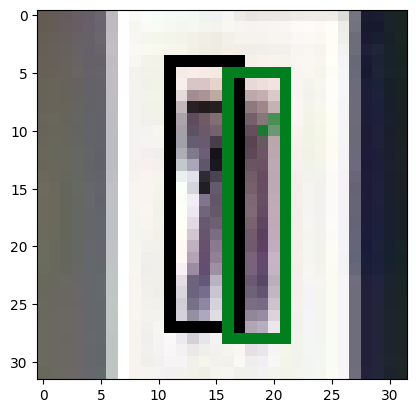

In [99]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

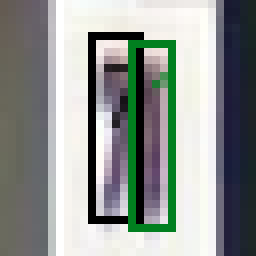

In [100]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [85]:
calculate_mAP(
    model,
    trainer.train_loader,
)

{'images': tensor([[[[0.3922, 0.3882, 0.3961,  ..., 0.0980, 0.1020, 0.1020],
          [0.3922, 0.3922, 0.4000,  ..., 0.0902, 0.1020, 0.1020],
          [0.3961, 0.4000, 0.3961,  ..., 0.1020, 0.0941, 0.1020],
          ...,
          [0.4157, 0.4118, 0.4196,  ..., 0.1333, 0.1137, 0.1137],
          [0.4157, 0.4118, 0.4196,  ..., 0.1373, 0.1176, 0.1176],
          [0.4078, 0.4157, 0.4235,  ..., 0.1373, 0.1098, 0.1137]],

         [[0.3569, 0.3608, 0.3647,  ..., 0.1137, 0.1333, 0.1451],
          [0.3569, 0.3647, 0.3686,  ..., 0.1020, 0.1333, 0.1451],
          [0.3686, 0.3686, 0.3765,  ..., 0.1176, 0.1294, 0.1490],
          ...,
          [0.4157, 0.4118, 0.4078,  ..., 0.1451, 0.1412, 0.1490],
          [0.4157, 0.4118, 0.4078,  ..., 0.1490, 0.1451, 0.1529],
          [0.4078, 0.4157, 0.4118,  ..., 0.1490, 0.1373, 0.1490]],

         [[0.3216, 0.3412, 0.3647,  ..., 0.1961, 0.1647, 0.1294],
          [0.3216, 0.3412, 0.3686,  ..., 0.1843, 0.1647, 0.1294],
          [0.3294, 0.3490, 0.36

In [50]:
bboxes = bounding_boxes[0]["bboxes"]
bboxes.shape

torch.Size([1, 4])

In [51]:
model.inference(
    batch["images"]
)

yo
torch.Size([256, 15])
torch.Size([104])
torch.Size([256, 15])
torch.Size([103])


MiniYoloV3Output(pred=tensor([[[[ 2.6301e-01,  1.1285e+00,  2.8023e-01,  ...,  2.8835e-02,
           -1.4927e-01, -4.9492e-02],
          [ 1.7022e-01,  1.4169e+00,  2.0000e-01,  ...,  5.4323e-01,
           -3.7553e-01, -8.5517e-03],
          [-1.5368e-02,  1.9937e+00,  3.9534e-02,  ...,  1.5741e-01,
           -2.5589e-02, -1.4577e-01],
          ...,
          [ 2.0871e-01,  2.6044e+00,  4.2321e-02,  ...,  2.9484e-01,
           -3.1334e-01, -1.9578e-01],
          [ 8.4038e-03,  3.7432e+00, -3.7127e-01,  ...,  1.4897e-01,
           -8.3144e-04, -4.7474e-01],
          [-9.1751e-02,  4.3127e+00, -5.7807e-01,  ..., -5.8029e-03,
            4.9528e-03, -1.6364e-01]],

         [[ 1.9098e-01,  8.7562e-01,  3.5471e-01,  ...,  1.4443e-02,
           -2.1448e-01,  4.5689e-02],
          [ 8.6966e-02,  9.7153e-01,  2.4274e-01,  ...,  7.4344e-02,
           -4.5126e-01,  1.1620e-01],
          [-1.2106e-01,  1.1634e+00,  1.8820e-02,  ...,  1.3752e-01,
            3.9443e-01,  9.8745e-02]

In [109]:
model.inference(batch["images"])